In [1]:
from datetime import date
import datetime 
import shutil
import pandas as pd
import yfinance as yf
pd.set_option('display.max_rows',None)
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
import openpyxl


def move_download(TICKER):
    source = f'C:/Users/joaom/Downloads/{TICKER}.csv'
    destination = 'C:/Users/joaom/OneDrive/Documentos/GitHub/Snp1000/Performance Tables'
    dest = shutil.move(source, destination) 

companies = pd.read_csv('03_Tables/SnP1000_TICKR.csv')
companies_list = companies['Companie'].to_list()
df = pd.DataFrame()

today = date.today()
current_day = int(today.strftime('%d'))
current_month = int(today.strftime('%m'))
current_year = int('20'+today.strftime('%y'))

start = datetime.date(2020,10,19)
end = datetime.date(current_year,current_month,current_day)

#Module 1 - Get data
companies_list=['TSLA']
for i in companies_list[:1]:
    print(str(companies_list.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)
    try:
        stock = []
        stock = yf.download(i, start=start, end=end, progress=False)
        if len(stock) == 0:
            None
        else:
            stock['Name'] = i
            df = df.append(stock, sort=False)
    except Exception:
        None


0 : TSLA,

In [2]:
#Module 2 - Calculate RSI (relative Strength Index)
#df = df.iloc[-60:] # Get just about the last two months of data

df.reset_index(inplace=True)
df['Change'] = (df['Close'].shift(-1)-df['Close']).shift(1)
df['ChangeAverage'] = df['Change'].rolling(window=2).mean()
df['ChangeAverage+'] = df.apply(lambda x: x['ChangeAverage'] if x['ChangeAverage'] > 0 else 0,axis=1).rolling(window=14).mean()
df['ChangeAverage-'] = df.apply(lambda x: x['ChangeAverage'] if x['ChangeAverage'] < 0 else 0,axis=1).rolling(window=14).mean()*-1
df['RSI'] = 100-(100/(1+(df['ChangeAverage+']/df['ChangeAverage-'])))
df = df.drop(columns = ['ChangeAverage','ChangeAverage','ChangeAverage'])


In [3]:
#Module 3 - Calculate OBV (On Balance Volume) 
VolumeList = df['Volume'].tolist()
OBV = [VolumeList[0]]
i=1
for i in range(1,len(VolumeList)):
    #i=i+1
    if VolumeList[i] > VolumeList[i-1]:
        OBV.append(OBV[i-1]+VolumeList[i])
        continue
    if VolumeList[i]==VolumeList[i-1]:
        OBV.append(OBV[i-1]+0)
        continue
    if VolumeList[i]<VolumeList[i-1]:
        OBV.append(OBV[i-1]-VolumeList[i])
        continue  
df['OBV'] = OBV

#Module 4 - Calculate Linear Regressions on Close and OBV plus errors

delay=5 # How many trading days to calculate moving slopes

OBV_regression = [0 for x in range(delay)]
OBV_regression_err = [0 for x in range(delay)]
Close_regression = [0 for x in range(delay)]
Close_regression_err = [0 for x in range(delay)]

Date = df['Date'].tolist()
x = np.array([x for x in range(delay)])
for i in range(delay,len(OBV)):
    y = df['OBV'].iloc[i-delay:i].values
    y2 = df['Close'].iloc[i-delay:i].values
    slope, intercept, r_value, p_value, err = stats.linregress(x,y)
    slope2, intercept2, r_value2, p_value2, err2 = stats.linregress(x,y2)
    #value = LinearRegression().fit(x,y).coef_[0]
    OBV_regression.append(slope)
    OBV_regression_err.append(err)
    Close_regression.append(slope2)
    Close_regression_err.append(err2)

df['OBV_Regression'] = OBV_regression
df['OBV_Regression_err'] = OBV_regression_err
df['Close_Regression'] = Close_regression
df['Close_Regression_err'] = Close_regression_err


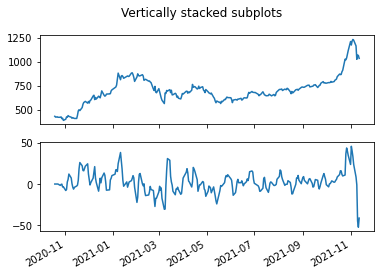

In [4]:
from matplotlib.dates import DateFormatter

fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')

axs[0].plot(df['Date'], df['Close'])
axs[1].plot(df['Date'], df['Close_Regression'])

fig.autofmt_xdate()
plt.show()

In [5]:
#Export to Excel (clean excel sheet initially to always paste correctly)
filename = 'output1.xlsx'
df.to_excel(filename)
print('DataFrame is written successfully to Excel Sheet.')

DataFrame is written successfully to Excel Sheet.


In [6]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Change,ChangeAverage+,ChangeAverage-,RSI,OBV,OBV_Regression,OBV_Regression_err,Close_Regression,Close_Regression_err
0,2020-10-19,446.239990,447.000000,428.869995,430.829987,430.829987,36287800,TSLA,NaN,NaN,NaN,NaN,36287800,0.0,0.000000e+00,0.000000,0.000000
1,2020-10-20,431.750000,431.750000,419.049988,421.940002,421.940002,31656300,TSLA,-8.889984,NaN,NaN,NaN,4631500,0.0,0.000000e+00,0.000000,0.000000
2,2020-10-21,422.700012,432.950012,421.250000,422.640015,422.640015,32370500,TSLA,0.700012,NaN,NaN,NaN,37002000,0.0,0.000000e+00,0.000000,0.000000
3,2020-10-22,441.920013,445.230011,424.510010,425.790009,425.790009,39993200,TSLA,3.149994,NaN,NaN,NaN,76995200,0.0,0.000000e+00,0.000000,0.000000
4,2020-10-23,421.839996,422.890015,407.380005,420.630005,420.630005,33717000,TSLA,-5.160004,NaN,NaN,NaN,43278200,0.0,0.000000e+00,0.000000,0.000000
5,2020-10-26,411.630005,425.760010,410.000000,420.279999,420.279999,28239200,TSLA,-0.350006,NaN,NaN,NaN,15039000,8634450.0,7.972665e+06,-1.654996,1.143721
6,2020-10-27,423.760010,430.500000,420.100006,424.679993,424.679993,22686500,TSLA,4.399994,NaN,NaN,NaN,-7647500,2709120.0,1.013685e+07,-0.533002,0.740362
7,2020-10-28,416.480011,418.600006,406.000000,406.019989,406.019989,25451400,TSLA,-18.660004,NaN,NaN,NaN,17803900,-15125520.0,7.624994e+06,-0.143005,0.882323
8,2020-10-29,409.959991,418.059998,406.459991,410.829987,410.829987,22655300,TSLA,4.809998,NaN,NaN,NaN,-4851400,-16930830.0,6.593263e+06,-3.549005,2.033357
9,2020-10-30,406.899994,407.589996,379.109985,388.040009,388.040009,42511300,TSLA,-22.789978,NaN,NaN,NaN,37659900,-9349430.0,5.210560e+06,-3.386005,2.046023
